# Определение стоимости автомобилей

## Подготовка данных

**Импорт библиотек**

In [53]:
#pip install missingno

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

import lightgbm as lgb

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.dummy import DummyRegressor

import missingno 


import warnings
warnings.filterwarnings('ignore')

---
**Импорт данных**

In [55]:
# импортируем данные
try: 
    data = pd.read_csv('/datasets/autos.csv') # путь в сетевой версии
except:
    data = pd.read_csv('autos.csv') # путь в локальной версии

In [56]:
data_raw_shape = data.shape
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

---
**Удаление пропусков**

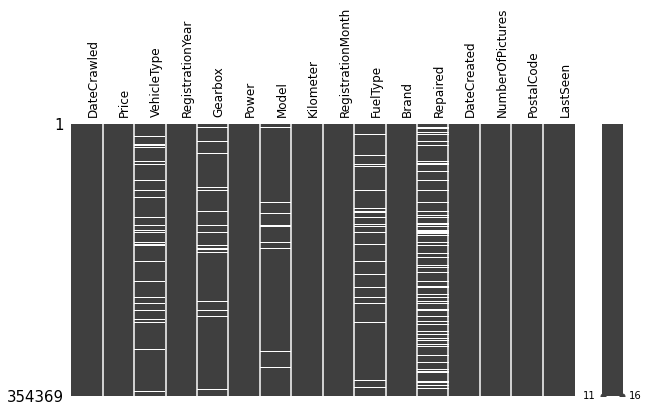

In [58]:
missingno.matrix(data,figsize=(10,5), fontsize=12, label_rotation=90);

Пропуска распределены хаотично, будем проверять каждую колонку отдельно

In [59]:
data.isna().sum().loc[lambda x : x != 0] # отобразим только колонки с пропусками

VehicleType    37490
Gearbox        19833
Model          19705
FuelType       32895
Repaired       71154
dtype: int64

In [60]:
# VehicleType
print(
    data.groupby(by='VehicleType', dropna=False)
    .agg( count=('Price', 'count'), median_price=('Price', 'median'))
)
# добавим отдельную категорию unknown, т.к. 
# медиана цены на авто без указания типа кузова сильно ниже остальных
data['VehicleType'].fillna('unknown', inplace=True)

             count  median_price
VehicleType                     
bus          28775          4200
convertible  20203          5500
coupe        16163          3950
other         3288          2200
sedan        91457          2999
small        79831          1500
suv          11996          8500
wagon        65166          3200
NaN          37490          1199


In [61]:
# Gearbox
print(
    data.groupby(by='Gearbox', dropna=False)
    .agg( count=('Price', 'count'), median_price=('Price', 'median'))
)

# тип коробки - важный параметр, значительно влияющий на стоимость. 
# стоимость без указания типа коробки значительно ниже более дешевой ручной коробки
# что не соответствет логике
# Удалим пропуски.
data.dropna(subset=['Gearbox'], inplace=True)

          count  median_price
Gearbox                      
auto      66285          5500
manual   268251          2490
NaN       19833          1000


In [62]:
# FuelType
print(
    data.groupby(by='FuelType', dropna=False)
    .agg( count=('Price', 'count'), median_price=('Price', 'median'))
)
# присвоим пропускам значение близкой по цене и немногочисленной категории other
data['FuelType'].fillna('other', inplace=True)

           count  median_price
FuelType                      
cng          551        3799.0
electric      78        5869.5
gasoline   95126        5450.0
hybrid       227       10500.0
lpg         5174        2990.0
other        150        1025.0
petrol    209255        2140.0
NaN        23975        1300.0


In [63]:
# Repaired
print(
    data.groupby(by='Repaired', dropna=False)
    .agg( count=('Price', 'count'), median_price=('Price', 'median'))
)
# Объявления без указания ремонта находятся где-то посередине по стоимости
# количество таких объявлений высоко, 
#при этом невозможно однозначно понять, был или не был ремонт  
# Создадим отдельную категорию unknown для отсутствующих данных по ремонту
data['Repaired'].fillna('unknown', inplace=True)


           count  median_price
Repaired                      
no        241629          3700
yes        34541           950
NaN        58366          1500


In [64]:
# Model 
for brand in data['Brand'].unique():
    print(brand, '-'*30)
    display(
        data.loc[data['Brand'] == brand].groupby(by='Model', dropna=False)
        .agg( count=('Price', 'count'), median_price=('Price', 'median'))
    ) 
data['Model'].fillna('unknown', inplace=True)

volkswagen ------------------------------


,count,median_price
Model,,
amarok,15,15120.0
beetle,790,4999.5
bora,845,2350.0
caddy,1506,5300.0
cc,133,14500.0
eos,504,10500.0
fox,707,2800.0
golf,27757,2500.0
jetta,348,3997.0


audi ------------------------------


,count,median_price
Model,,
100,399,1199.0
200,16,3250.0
80,1512,950.0
90,92,1449.5
a1,588,13990.0
a2,354,3850.0
a3,5806,5100.0
a4,9514,4500.0
a5,539,16500.0


jeep ------------------------------


,count,median_price
Model,,
cherokee,163,4250.0
grand,235,5100.0
other,134,9900.0
wrangler,92,8450.0
NaN,20,4874.5


skoda ------------------------------


,count,median_price
Model,,
citigo,91,7299
fabia,2039,3500
octavia,2052,5850
other,246,800
roomster,272,6000
superb,362,10500
yeti,173,12990
NaN,127,2200


bmw ------------------------------


,count,median_price
Model,,
1er,3444,9140.0
3er,19086,3500.0
5er,7678,5200.0
6er,146,14200.0
7er,988,5500.0
i3,7,2600.0
m_reihe,118,13649.5
other,166,4800.0
x_reihe,1534,11900.0


peugeot ------------------------------


,count,median_price
Model,,
1_reihe,1149,950
2_reihe,4672,2500
3_reihe,2107,2350
4_reihe,613,2700
5_reihe,109,12999
other,1101,2700
NaN,753,1399


ford ------------------------------


,count,median_price
Model,,
b_max,25,12500
c_max,668,4800
escort,832,550
fiesta,5468,1500
focus,5658,1999
fusion,287,2800
galaxy,1085,2500
ka,2495,950
kuga,315,14900


mazda ------------------------------


,count,median_price
Model,,
1_reihe,94,600.0
3_reihe,1284,1350.0
5_reihe,319,5500.0
6_reihe,1243,2250.0
cx_reihe,62,13220.0
mx_reihe,972,3990.0
other,958,1700.0
rx_reihe,134,4899.5
NaN,276,994.5


nissan ------------------------------


,count,median_price
Model,,
almera,558,1350.0
juke,98,11495.0
micra,1670,1100.0
navara,94,9500.0
note,128,4500.0
other,681,4150.0
primera,595,1250.0
qashqai,516,12500.0
x_trail,203,5300.0


renault ------------------------------


,count,median_price
Model,,
clio,3379,1400
espace,575,1499
kangoo,896,1750
laguna,1309,1300
megane,2805,1750
modus,308,2900
other,902,4175
r19,113,600
scenic,1391,1699


mercedes_benz ------------------------------


,count,median_price
Model,,
a_klasse,3933,2200.0
b_klasse,847,8500.0
c_klasse,8073,3600.0
cl,219,7500.0
clk,1776,5400.0
e_klasse,6638,4499.5
g_klasse,92,11000.0
gl,13,18999.0
glk,63,17900.0


opel ------------------------------


,count,median_price
Model,,
agila,403,1499.0
antara,104,8999.5
astra,10357,1799.0
calibra,197,1300.0
combo,385,2450.0
corsa,11791,1099.0
insignia,624,11422.0
kadett,310,1374.0
meriva,1012,3699.5


seat ------------------------------


,count,median_price
Model,,
alhambra,344,3650
altea,358,5499
arosa,845,999
cordoba,373,800
exeo,100,11000
ibiza,2616,2625
leon,1277,5950
mii,80,7550
other,101,800


citroen ------------------------------


,count,median_price
Model,,
berlingo,794,2150.0
c1,376,3574.5
c2,375,2500.0
c3,487,3250.0
c4,429,5300.0
c5,476,2794.5
other,1729,1300.0
NaN,212,960.0


honda ------------------------------


,count,median_price
Model,,
accord,340,3350
civic,1289,1450
cr_reihe,335,4750
jazz,293,3800
other,308,2200
NaN,128,1325


fiat ------------------------------


,count,median_price
Model,,
500,878,7625.0
bravo,307,2600.0
croma,43,3500.0
doblo,313,2900.0
ducato,406,3000.0
other,1684,1990.0
panda,647,2950.0
punto,3114,1099.0
seicento,608,777.0


mini ------------------------------


,count,median_price
Model,,
clubman,195,9999
cooper,1917,8999
one,877,6600
other,82,7888
NaN,56,6608


smart ------------------------------


,count,median_price
Model,,
forfour,359,2660
fortwo,3551,3000
other,54,1625
roadster,159,5000
NaN,208,1750


hyundai ------------------------------


,count,median_price
Model,,
getz,400,1900
i_reihe,1199,7200
other,1123,1700
santa,307,4500
tucson,222,6299
NaN,203,1950


sonstige_autos ------------------------------


,count,median_price
Model,,
NaN,2271,5200


alfa_romeo ------------------------------


,count,median_price
Model,,
145,40,600.0
147,549,1999.0
156,601,1200.0
159,209,6450.0
other,496,5900.0
spider,176,5519.5
NaN,111,999.0


subaru ------------------------------


,count,median_price
Model,,
forester,126,3990
impreza,214,2475
justy,133,850
legacy,156,1175
other,63,3999
NaN,37,800


volvo ------------------------------


,count,median_price
Model,,
850,204,950
c_reihe,191,7200
other,549,1999
s60,144,4472
v40,750,1000
v50,252,5500
v60,40,16495
v70,610,2825
xc_reihe,259,10750


mitsubishi ------------------------------


,count,median_price
Model,,
carisma,401,850
colt,831,1950
galant,251,800
lancer,199,2490
other,742,1750
outlander,121,9500
pajero,202,4825
NaN,133,999


kia ------------------------------


,count,median_price
Model,,
carnival,260,1797
ceed,246,6300
other,482,1850
picanto,357,2900
rio,361,2550
sorento,326,6500
sportage,242,12500
NaN,102,1725


suzuki ------------------------------


,count,median_price
Model,,
grand,205,7600
jimny,201,6333
other,1000,1790
swift,681,3890
NaN,110,1450


lancia ------------------------------


,count,median_price
Model,,
delta,32,5600
elefantino,11,550
kappa,13,1950
lybra,51,700
musa,24,3199
other,93,2800
ypsilon,199,950
NaN,22,1175


toyota ------------------------------


,count,median_price
Model,,
auris,231,7800.0
avensis,552,4800.0
aygo,410,3970.0
corolla,661,2350.0
other,807,3200.0
rav,338,6450.0
verso,303,6000.0
yaris,1003,3350.0
NaN,128,2999.5


chevrolet ------------------------------


,count,median_price
Model,,
aveo,109,4250.0
captiva,168,9474.5
matiz,276,2150.0
other,895,4900.0
spark,122,4890.0
NaN,88,3500.0


dacia ------------------------------


,count,median_price
Model,,
duster,197,9799
lodgy,34,10675
logan,314,2990
other,20,6525
sandero,292,4325
NaN,21,6600


daihatsu ------------------------------


,count,median_price
Model,,
charade,27,550
cuore,349,800
materia,18,4650
move,52,600
other,107,1500
sirion,134,2250
terios,33,5000
NaN,32,935


saab ------------------------------


,count,median_price
Model,,
900,110,1477.5
9000,29,2249.0
other,358,2800.0
NaN,14,975.0


chrysler ------------------------------


,count,median_price
Model,,
300c,140,9500
crossfire,63,9800
grand,107,2950
other,371,2000
ptcruiser,298,2050
voyager,325,1200
NaN,73,1300


jaguar ------------------------------


,count,median_price
Model,,
other,183,9990
s_type,126,3525
x_type,165,3800
NaN,13,2700


daewoo ------------------------------


,count,median_price
Model,,
kalos,92,1450.0
lanos,85,600.0
matiz,148,1025.0
nubira,61,850.0
other,86,1099.5
NaN,36,650.0


porsche ------------------------------


,count,median_price
Model,,
911,59,15490
boxster,210,13850
cayenne,227,12999
other,156,7400
NaN,25,4950


rover ------------------------------


,count,median_price
Model,,
defender,1,550
discovery,2,2950
freelander,3,1950
other,374,950
rangerover,4,2900
NaN,70,625


land_rover ------------------------------


,count,median_price
Model,,
defender,65,12500
discovery,75,10500
freelander,209,3999
other,15,7500
range_rover,75,5999
range_rover_evoque,2,12500
range_rover_sport,53,15200
serie_1,1,3800
serie_2,8,7725


trabant ------------------------------


,count,median_price
Model,,
601,284,1215
other,47,1750
NaN,36,1250


lada ------------------------------


,count,median_price
Model,,
kalina,9,2100
niva,118,3299
other,51,2222
samara,13,300
NaN,11,1399


In [65]:
# пропуски в категориальных полях. заполним все как 'unknown'
data.fillna('unknown', inplace=True)
#data.dropna(inplace=True)

---
**Преобразуем форматы данных**

In [66]:
# object -> datetime
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%Y-%m-%d')
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format='%Y-%m-%d')
data['LastSeen'] = pd.to_datetime(data['LastSeen'], format='%Y-%m-%d')

---
**Устранение аномалий**

In [67]:
# отобразим раскладку по всем столбцам

display(data.describe().T)

,count,mean,std,min,25%,50%,75%,max
Price,334536.0,4547.697291,4551.131380,0.0,1150.0,2850.0,6500.0,20000.0
RegistrationYear,334536.0,2003.379122,32.059005,1000.0,1999.0,2003.0,2008.0,9000.0
Power,334536.0,114.457544,190.479544,0.0,75.0,105.0,143.0,20000.0
Kilometer,334536.0,128777.590454,36894.507459,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,334536.0,5.857955,3.655664,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,334536.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,334536.0,50637.655367,25802.916894,1067.0,30177.0,49497.0,71254.0,99998.0


Аномалии:
- Price - есть нулевые цены
- RegistrationYear - есть нереально маленькие и большие года выпуска
- Power - разброс мощности от 0 до 20000
- RegistrationMonth - есть нулевые месяца

---
**Price**

<AxesSubplot:ylabel='Frequency'>

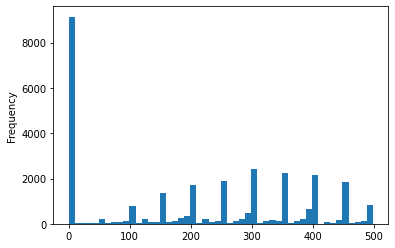

In [68]:
# отобразим на графике самые низкие цены на авто
data.query('Price<500')['Price'].plot(kind='hist', bins=50)

In [69]:
# удалим цены <50 EUR  
data =   data.query('Price>=50') 

---
**RegistrationYear** 

В выборке встречаются заведомо некоррректные значения годов регистрации авто. Удалим такие объявления из выборки.

In [70]:
# найдем крайний год создания объявлений. 
# Авто не могло быть зарегистрировано позднее этого года
last_year = data['DateCreated'].dt.year.max()
last_year

2016

<AxesSubplot:ylabel='Frequency'>

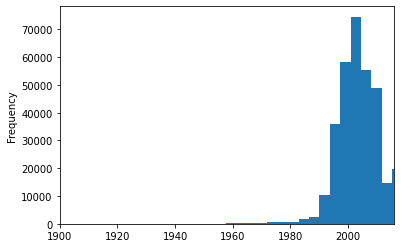

In [71]:
data['RegistrationYear'].plot(kind='hist', bins=2000, xlim=(1900,last_year))

In [72]:
# удалим объявления с завышенным годом выпуска
data = data.loc[data['RegistrationYear']<= last_year]
# удалим объявления с заниженным годом выпуска
data = data.loc[data['RegistrationYear']>1950]

---
**Power**

<AxesSubplot:ylabel='Frequency'>

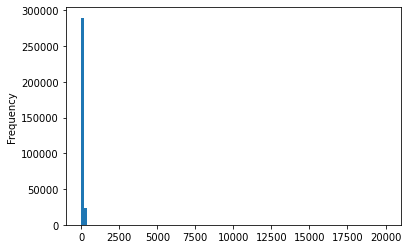

In [73]:
data['Power'].plot(kind='hist', bins=100)

In [74]:
# удалим объявления с завышенной мощностью
data = data.loc[data['Power']<= 500]

107.0


<AxesSubplot:ylabel='Frequency'>

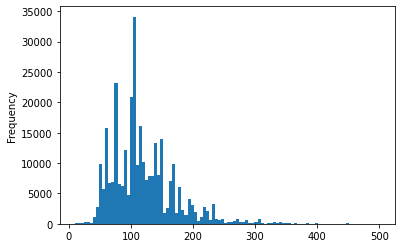

In [75]:
# заполним нулевые значения мощности медианным значением мощности
median_power = data['Power'].median()
print(median_power)
data.loc[data['Power']<10, 'Power'] = median_power
data['Power'].plot(kind='hist', bins=100)

---
**RegistrationMonth**

В поле RegistrationMonth встречаются нулевые значения. Видимо, они не указаны пользователем. Заменим 0 на 6 (середина года)

In [76]:
data['RegistrationMonth'].value_counts()

3     31793
6     28735
4     26873
5     26737
7     24990
10    24025
12    22202
0     22195
9     21976
11    21964
1     21092
8     20690
2     19539
Name: RegistrationMonth, dtype: int64

In [77]:
data['RegistrationMonth'] = data['RegistrationMonth'].replace(0,6)

---
**Добавим вычисляемую переменную возраста автомобиля**

Возраст авто - один из основополагающих параметров при определении стоимости продажи. В исходных данных такого параметра нет, потому вычислим его в отдельном столбце.

In [78]:
# создадим поле datetime с годом и месяцем регистрации авто
data['DateRegistration'] = pd.to_datetime({
    'year': data['RegistrationYear'],
    'month': data['RegistrationMonth'],
    'day': 1})

In [79]:
# посчитаем возраст авто на момент создания объявления 
data['AgeYears'] = data['DateCreated'] - data['DateRegistration']
data['AgeYears'] = (data['AgeYears'] / np.timedelta64(1,'Y')).astype('int')

In [80]:
data[['DateRegistration', 'DateCreated', 'AgeYears']].head()

,DateRegistration,DateCreated,AgeYears
0,1993-06-01,2016-03-24,22
1,2011-05-01,2016-03-24,4
2,2004-08-01,2016-03-14,11
3,2001-06-01,2016-03-17,14
4,2008-07-01,2016-03-31,7


---
**Удалим лишние колонки**

Ряд колонок не потребуется для целей последующего обучения модели расчета продажной цены.

In [81]:
data = data.drop(columns=[
    'DateCrawled', 'RegistrationYear', 'RegistrationMonth', 
    'DateCreated', 'NumberOfPictures', 'PostalCode',
    'LastSeen', 'DateRegistration'])

In [82]:
data.shape

(312811, 10)

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312811 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Price        312811 non-null  int64  
 1   VehicleType  312811 non-null  object 
 2   Gearbox      312811 non-null  object 
 3   Power        312811 non-null  float64
 4   Model        312811 non-null  object 
 5   Kilometer    312811 non-null  int64  
 6   FuelType     312811 non-null  object 
 7   Brand        312811 non-null  object 
 8   Repaired     312811 non-null  object 
 9   AgeYears     312811 non-null  int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 26.3+ MB


---
**Проверка на мультиколлинеарность**

<AxesSubplot:>

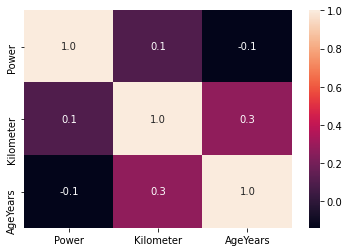

In [84]:
sns.heatmap(data[['Power', 'Kilometer', 'AgeYears']].corr(), annot=True, fmt='.1f')

Числовые признаки слабо коррелируют между собой, мультиколлинеарности не обнаружено.

In [85]:
print('Размер изначальной выборки', data_raw_shape)
print('Размер обработанной выборки', data.shape)

Размер изначальной выборки (354369, 16)
Размер обработанной выборки (312811, 10)


---
**Промежуточные выводы**
- данные импортировались без проблем
- типы данных, за исключением дат, соответствуют самим данным
- в выборке было большое количество пропусков, но только в категориальных переменных
- все пропуски были заменены либо удалены
- встретился ряд аномалий
    - год регистрации - ошибочные года были удалены
    - мощность - ошибочная мощность была заменена на медианное значение
    - цена - нулевые цены были удалены
    - нулевые месяцы регистрации - были заменены на 6 (середина года)
- был расчитан возраст авто на момент подачи объявления
- проверка на мультиколлинеарность числовых признаков не показала проблем
- в результате обработки исходной выборки было удалено 11.7% строк

## Обучение моделей

**Функция метрики RMSE**

Согласно задания, для оценки качества моделей следует применять метрику RMSE. Добавим функцию для ее расчета и последующего использования в GridSearch.

In [86]:
def rmse(real, predictions):
    return mean_squared_error(real, predictions) ** 0.5

**Разбиение на выборки**

In [87]:
target = data['Price']
features = data.drop('Price', axis=1)

In [88]:
# разделяем исходные данные на обучающую(60%) валидационную (20%) и тестовую(20%) выборки

# первым шагом отделяем тестовые данные
features_train, features_test, target_train, target_test = train_test_split(
   features, target, test_size=0.2, random_state=0)

# вторым шагом отделяем валидационные данные
features_train, features_valid, target_train, target_valid = train_test_split(
   features_train, target_train, test_size=0.25, random_state=0)

In [89]:
print(features_train.shape, features_valid.shape, features_test.shape)

(187686, 9) (62562, 9) (62563, 9)


In [90]:
features_train.head()

,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,AgeYears
19187,sedan,manual,131.0,a3,150000,gasoline,audi,no,14
39329,wagon,auto,90.0,golf,150000,gasoline,volkswagen,no,19
268100,sedan,auto,75.0,astra,150000,petrol,opel,unknown,20
100653,small,manual,65.0,picanto,125000,lpg,kia,no,9
136660,small,manual,101.0,polo,150000,gasoline,volkswagen,unknown,10


---
**Кодирование категориальных переменных методом OHE**

In [91]:
categories = ['VehicleType','Gearbox','Model','FuelType','Brand','Repaired']

In [92]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Apply one-hot encoder to each column with categorical data
features_train_ohe = pd.DataFrame(ohe.fit_transform(features_train[categories]))
features_valid_ohe = pd.DataFrame(ohe.transform(features_valid[categories]))
features_test_ohe = pd.DataFrame(ohe.transform(features_test[categories]))

# One-hot encoding removed index; put it back
features_train_ohe.index = features_train.index
features_valid_ohe.index = features_valid.index
features_test_ohe.index = features_test.index

# Remove categorical columns (will replace with one-hot encoding)
numeric_train = features_train.drop(categories, axis=1)
numeric_valid = features_valid.drop(categories, axis=1)
numeric_test = features_test.drop(categories, axis=1)

# Add one-hot encoded columns to numerical features
features_train_ohe = pd.concat([numeric_train, features_train_ohe], axis=1)
features_valid_ohe = pd.concat([numeric_valid, features_valid_ohe], axis=1)
features_test_ohe = pd.concat([numeric_test, features_test_ohe], axis=1)

print(features_train_ohe.shape)
print(features_valid_ohe.shape)
print(features_test_ohe.shape)

(187686, 315)
(62562, 315)
(62563, 315)


---
**Кодирование категориальных переменных методом OrdinalEncoding**

In [93]:
enc = OrdinalEncoder()#handle_unknown='use_encoded_value', unknown_value=-1)

features_train_encoded = features_train
features_valid_encoded = features_valid
features_test_encoded = features_test

features_train_encoded[categories] = enc.fit_transform(features_train[categories])
features_valid_encoded[categories] = enc.transform(features_valid[categories])
features_test_encoded[categories] = enc.transform(features_test[categories])

print(features_train_encoded.shape)
print(features_valid_encoded.shape)
print(features_test_encoded.shape)

(187686, 9)
(62562, 9)
(62563, 9)


In [94]:

display(features_train_encoded.head())
display(features_valid_encoded.head())
display(features_test_encoded.head())

,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,AgeYears
19187,4.0,1.0,131.0,28.0,150000,2.0,1.0,0.0,14
39329,8.0,0.0,90.0,116.0,150000,2.0,38.0,0.0,19
268100,4.0,0.0,75.0,42.0,150000,6.0,24.0,1.0,20
100653,5.0,1.0,65.0,172.0,125000,4.0,15.0,0.0,9
136660,5.0,1.0,101.0,173.0,150000,2.0,38.0,1.0,10


,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,AgeYears
297096,1.0,1.0,150.0,249.0,125000,6.0,2.0,0.0,15
109846,1.0,1.0,116.0,42.0,50000,6.0,24.0,0.0,8
222881,5.0,1.0,50.0,102.0,150000,6.0,10.0,0.0,15
258765,5.0,1.0,75.0,228.0,150000,6.0,38.0,1.0,13
254927,7.0,0.0,107.0,228.0,150000,6.0,32.0,1.0,0


,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,AgeYears
6979,6.0,0.0,200.0,228.0,150000,2.0,20.0,0.0,8
282879,4.0,1.0,120.0,136.0,150000,6.0,27.0,1.0,11
149167,8.0,1.0,90.0,170.0,150000,6.0,38.0,1.0,22
322589,2.0,1.0,158.0,166.0,80000,6.0,0.0,2.0,30
203825,1.0,1.0,231.0,249.0,125000,6.0,2.0,0.0,10


**Удалим ненужные переменные**

In [95]:
del data
del target
del features

**Модель линейной регрессии**

In [96]:
best_model_lr = LinearRegression()
%timeit -r 1 best_model_lr.fit(features_train_ohe, target_train)

print('-'*50)
print("RMSE лучшей модели:", rmse(target_valid, best_model_lr.predict(features_valid_ohe)))
print('-'*50)
print('Training accuracy {:.4f}'.format(best_model_lr.score(features_train_ohe,target_train)))
print('Testing accuracy {:.4f}'.format(best_model_lr.score(features_valid_ohe,target_valid)))
print('-'*50)

17.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
--------------------------------------------------
RMSE лучшей модели: 2582.7745682163772
--------------------------------------------------
Training accuracy 0.6807
Testing accuracy 0.6834
--------------------------------------------------


---
**Модель случайного леса**

In [97]:
# гиперпараметры для подбора оптимальных результатов
# подставлено оптимальное полученное значение из 9 комбинаций, т.к. очень долго пересчитывается
params = {'n_estimators': [100], # [50,100,500]
             'max_depth': [10] } # [2,5,10]

# переберем параметры в цикле, т.к. GridSearchCV отказался работать в веб версии
best_model_rfr = None
best_result_rfr = 999_999_999
best_est_rfr = 0
best_depth_rfr = 0

for est in params.get('n_estimators'):
    for depth in params.get('max_depth'):
        model = RandomForestRegressor(random_state=0,n_estimators=est, max_depth =depth)
        %timeit -r 1 model.fit(features_train_encoded, target_train)
        
        predictions = model.predict(features_valid_encoded)
        result = rmse(target_valid, predictions)
        print('est=', est, 'depth=', depth, 'rmse=', result)
                   
        if result < best_result_rfr:
            best_model_rfr = model
            best_result_rfr = result
            best_est_rfr = est
            best_depth_rfr = depth

print('-'*50)
print("RMSE лучшей модели:", best_result_rfr)
print("Количество деревьев:", best_est_rfr)
print("max_depth лучшей модели:", best_depth_rfr)
print('-'*50)
print('Training accuracy {:.4f}'.format(best_model_rfr.score(features_train_encoded,target_train)))
print('Testing accuracy {:.4f}'.format(best_model_rfr.score(features_valid_encoded,target_valid)))
print('-'*50)

23 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
est= 100 depth= 10 rmse= 1891.128381959121
--------------------------------------------------
RMSE лучшей модели: 1891.128381959121
Количество деревьев: 100
max_depth лучшей модели: 10
--------------------------------------------------
Training accuracy 0.8451
Testing accuracy 0.8303
--------------------------------------------------


**Модель LightBGM**

In [98]:
# гиперпараметры для подбора оптимальных результатов
# подставлено оптимальное полученное значение из 9 комбинаций
params = {'learning_rate': [1], # [0.01, 0.1, 1]
             'max_depth': [12] } # [3,6,12]

best_model_lgb = None
best_result_lgb = 999_999_999
best_rate_lgb = 0
best_depth_lgb = 0

for rate in params.get('learning_rate'):
    for depth in params.get('max_depth'):
        model = lgb.LGBMRegressor(learning_rate=rate,max_depth=depth,random_state=0)
        %timeit -r 1 model.fit(features_train_ohe,target_train, verbose=50)
        
        predictions = model.predict(features_valid_ohe)
        result = rmse(target_valid, predictions)
        print('rate=', rate, 'depth=', depth, 'rmse=', result)
                   
        if result < best_result_lgb:
            best_model_lgb = model
            best_result_lgb = result
            best_rate_lgb = rate
            best_depth_lgb = depth

print('-'*50)
print("RMSE лучшей модели:", best_result_lgb)
print("Скорость обучения:", best_rate_lgb)
print("max_depth лучшей модели:", best_depth_lgb)
print('-'*50)
print('Training accuracy {:.4f}'.format(best_model_lgb.score(features_train_ohe,target_train)))
print('Testing accuracy {:.4f}'.format(best_model_lgb.score(features_valid_ohe,target_valid)))
print('-'*50)

5.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
rate= 1 depth= 12 rmse= 1681.4995588509744
--------------------------------------------------
RMSE лучшей модели: 1681.4995588509744
Скорость обучения: 1
max_depth лучшей модели: 12
--------------------------------------------------
Training accuracy 0.8917
Testing accuracy 0.8658
--------------------------------------------------


---
**Промежуточные выводы**

- Полная выборка была разделена на 3 подвыборки: обучающую, валидационную и тестовую в пропорции 60% - 20% - 20%
- Обучены 3 модели регрессии
    - Линейная модель. Время обучения = `17.5 s`, RMSE = `2582`
    - Случайный лес. Время обучения = `24,8 s`, RMSE лучшей модели = `1891`
    - LightBGM (градиентный бустинг). Время обучения = `6.8 s`, RMSE лучшей модели = `1681`

## Анализ моделей

**Скорость работы моделей**

Проверим скорость получения предсказаний моделей

In [99]:
%%timeit
# LinearRegression
predictions = best_model_lr.predict(features_valid_ohe)
#print('RMSE',rmse(target_valid, predictions))

240 ms ± 5.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [100]:
%%timeit
# RandomForestRegression
predictions = best_model_rfr.predict(features_valid_encoded)
#print('RMSE',rmse(target_valid, predictions))

528 ms ± 21.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [101]:
%%timeit
# LGBMRegressor
predictions = best_model_lgb.predict(features_valid_ohe)
#print('RMSE',rmse(target_valid, predictions))

641 ms ± 40.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Скорость получения предсказаний в результате тестов:
- 239 ms ± 9.32 ms для Линейной регрессии
- 529 ms ± 13.5 ms для Случайного леса
- 615 ms ± 30.7 ms для LightBGM

**Выбор лучшей модели**

Сведем воедино сравнительные показатели моделей

| Модель | Время обучения | Время работы | RMSE  |
| --- | --- | --- | --- |
| LinearRegression | 17.5 s | 239 ms ± 9.32 ms | 2582 |
| RandomForestRegression | 24.8 s | 529 ms ± 13.5 ms | 1891 |
| LGBMRegressor | 6.8 s | 615 ms ± 30.7 ms | 1681 |

Согласно критериям заказчика модель линейной регрессии не подходит из-за своей низкой точности (RMSE > 2500). Из двух оставшихся моделей наилучшая - LightBGM , т.к. имеет лучшую точность при меньшем времени обучения, нежели Случайный лес.

**Лучшая модель - LightBGM.**

---
**Тестирование лучшей модели**

In [102]:
#переобучим лучшую модель на объединенных данных из обучающей и валидационной выборок
features_combine_ohe = pd.concat([features_train_ohe,features_valid_ohe])
target_combine = pd.concat([target_train,target_valid])

model = lgb.LGBMRegressor(learning_rate=best_rate_lgb,max_depth=best_depth_lgb,random_state=0)
model.fit(features_combine_ohe,target_combine, verbose=50)
predictions = model.predict(features_test_ohe)
print('RMSE',rmse(target_test, predictions))

RMSE 1642.210824435947


___
**Итоговый вывод**

**Этап 1 : Подготовка данных**
- данные импортировались без проблем
- типы данных, за исключением дат, соответствуют самим данным
- в выборке было большое количество пропусков, но только в категориальных переменных
- все пропуски были заменены либо удалены
- встретился ряд аномалий
    - год регистрации - ошибочные года были удалены
    - мощность - ошибочная мощность была заменена на медианное значение
    - цена - нулевые цены были удалены
    - нулевые месяцы регистрации - были заменены на 6 (середина года)
- был расчитан возраст авто на момент подачи объявления
- проверка на мультиколлинеарность числовых признаков не показала проблем
- в результате обработки исходной выборки было удалено 11.7% строк

**Этап 2 : Обучение моделей**
- Полная выборка была разделена на 3 подвыборки: обучающую, валидационную и тестовую в пропорции 60% - 20% - 20%
- Обучены 3 модели регрессии
    - Линейная модель. Время обучения = `17.5 s`, RMSE = `2582`
    - Случайный лес. Время обучения = `24,8 s`, RMSE лучшей модели = `1891`
    - LightBGM (градиентный бустинг). Время обучения = `6.8 s`, RMSE лучшей модели = `1681`
    
**Этап 3 : Анализ моделей**
- Результаты работы 3х моделей сведены в таблицу
| Модель | Время обучения | Время работы | RMSE  |
| --- | --- | --- | --- |
| LinearRegression | 17.5 s | 239 ms ± 9.32 ms | 2582 |
| RandomForestRegression | 24.8 s | 529 ms ± 13.5 ms | 1891 |
| LGBMRegressor | 6.8 s | 615 ms ± 30.7 ms | 1681 |

- Предварительно лучшей моделью была выбрана LGBMRegressor
- Модель LGBMRegressor с наилучшими гиперпарамтерами была переобучена на протестирована на тестовой выборке
- **Метрика RMSE LGBMRegressor на тестовой выборке = 1642 соответствует условию задания.**